<a href="https://colab.research.google.com/github/19150shreya/resnet-50/blob/main/resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
# Instead of keras.wrappers.scikit_learn, use scikeras.wrappers
from scikeras.wrappers import KerasClassifier # Import KerasClassifier from scikeras.wrappers
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Mount your Google Drive
drive.mount('/content/drive')
#train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="training",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/train',
                                                   target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Mounted at /content/drive
Found 8235 images belonging to 4 classes.


In [ ]:
#valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="validation",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/train',
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 2058 images belonging to 4 classes.


In [ ]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/My Drive/test',
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(input_shape=(128,128,3),
                   include_top=False,
                   weights="imagenet")

base_model.save('https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32)                  │              

 Total params: 25,828,612 (98.53 MB)

 Trainable params: 2,174,852 (8.30 MB)

 Non-trainable params: 23,653,760 (90.23 MB)

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 8235 images belonging to 4 classes.
Found 2058 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,823,012 (98.51 MB)

 Trainable params: 2,169,444 (8.28 MB)

 Non-trainable params: 23,653,568 (90.23 MB)

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1515s 6s/step - accuracy: 0.7372 - auc: 0.5825 - f1_score: 0.1226 - loss: 1.4449 - precision: 0.3910 - recall: 0.0755 - val_accuracy: 0.7716 - val_auc: 0.7173 - val_f1_score: 0.2700 - val_loss: 1.1904 - val_precision: 0.6648 - val_recall: 0.1744 - learning_rate: 0.0100
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 86s 268ms/step - accuracy: 0.7556 - auc: 0.6779 - f1_score: 0.1608 - loss: 1.2669 - precision: 0.5651 - recall: 0.0954 - val_accuracy: 0.7799 - val_auc: 0.7621 - val_f1_score: 0.2260 - val_loss: 1.1343 - val_precision: 0.9184 - val_recall: 0.1312 - learning_rate: 0.0063
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 74s 280ms/step - accuracy: 0.7582 - auc: 0.6900 - f1_score: 0.1736 - loss: 1.2522 - precision: 0.5950 - recall: 0.1027 - val_accuracy: 0.7819 - val_auc: 0.7591 - val_f1_score: 0.2395 - val_loss: 1.1256 - val_precision: 0.9071 - val_recall: 0.1424 - learning_rate: 0.0040
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 79s 267ms/step - accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

     Mild Impairment       0.13      0.36      0.19       179
 Moderate Impairment       0.00      0.00      0.00        12
       No Impairment       0.50      0.53      0.52       640
Very Mild Impairment       0.00      0.00      0.00       448

            accuracy                           0.32      1279
           macro avg       0.16      0.22      0.18      1279
        weighted avg       0.27      0.32      0.29      1279



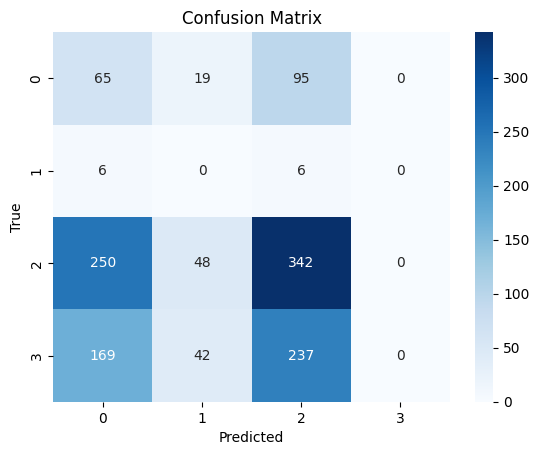

In [ ]:
# Install dependencies
!pip install scikeras

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_dataset = train_datagen.flow_from_directory(
    directory='/content/drive/My Drive/train',
    target_size=(128, 128),
    class_mode='categorical',
    subset='training',
    batch_size=32
)

valid_dataset = valid_datagen.flow_from_directory(
    directory='/content/drive/My Drive/train',
    target_size=(128, 128),
    class_mode='categorical',
    subset='validation',
    batch_size=32
)

test_dataset = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/test',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)

# Load the ResNet50 base model
base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Display the model summary
model.summary()

# Custom F1 Score
def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

# Metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

# Learning rate scheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

lr_scheduler = LearningRateScheduler(exponential_decay(0.01, 5))

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    verbose=1,
    callbacks=[lr_scheduler]
)

# Evaluate on the test set
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
y_true = test_dataset.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(test_dataset.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 8235 images belonging to 4 classes.
Found 2058 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,823,012 (98.51 MB)

 Trainable params: 2,169,444 (8.28 MB)

 Non-trainable params: 23,653,568 (90.23 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


258/258 ━━━━━━━━━━━━━━━━━━━━ 118s 302ms/step - accuracy: 0.7361 - auc: 0.5872 - f1_score: 0.1297 - loss: 1.4434 - precision: 0.3906 - recall: 0.0833 - val_accuracy: 0.7754 - val_auc: 0.7137 - val_f1_score: 0.2296 - val_loss: 1.1975 - val_precision: 0.7944 - val_recall: 0.1370 - learning_rate: 0.0100
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 70s 263ms/step - accuracy: 0.7546 - auc: 0.6798 - f1_score: 0.1477 - loss: 1.2627 - precision: 0.5561 - recall: 0.0870 - val_accuracy: 0.7707 - val_auc: 0.7361 - val_f1_score: 0.2093 - val_loss: 1.1697 - val_precision: 0.7471 - val_recall: 0.1249 - learning_rate: 0.0063
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 70s 263ms/step - accuracy: 0.7597 - auc: 0.6916 - f1_score: 0.1861 - loss: 1.2507 - precision: 0.6047 - recall: 0.1114 - val_accuracy: 0.7730 - val_auc: 0.7568 - val_f1_score: 0.2090 - val_loss: 1.1523 - val_precision: 0.8000 - val_recall: 0.1224 - learning_rate: 0.0040
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - accuracy: 0.7609 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


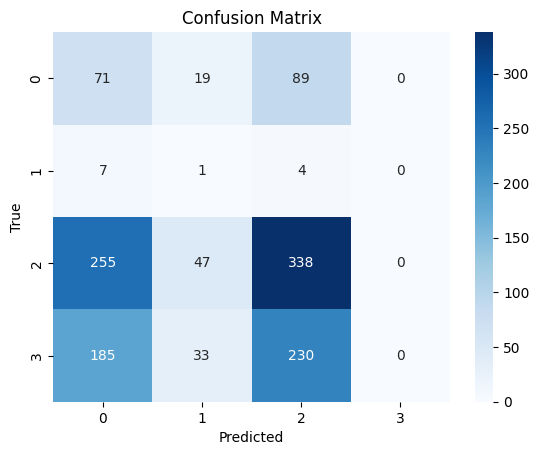

In [ ]:
# Install dependencies
!pip install scikeras

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_dataset = train_datagen.flow_from_directory(
    directory='/content/drive/My Drive/train',
    target_size=(128, 128),
    class_mode='categorical',
    subset='training',
    batch_size=32
)

valid_dataset = valid_datagen.flow_from_directory(
    directory='/content/drive/My Drive/train',
    target_size=(128, 128),
    class_mode='categorical',
    subset='validation',
    batch_size=32
)

test_dataset = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/test',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)

# Load the ResNet50 base model
base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Display the model summary
model.summary()

# Custom F1 Score
def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

# Metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

# Learning rate scheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

lr_scheduler = LearningRateScheduler(exponential_decay(0.01, 5))

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    verbose=1,
    callbacks=[lr_scheduler]
)

# Evaluate on the test set
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
y_true = test_dataset.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(test_dataset.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


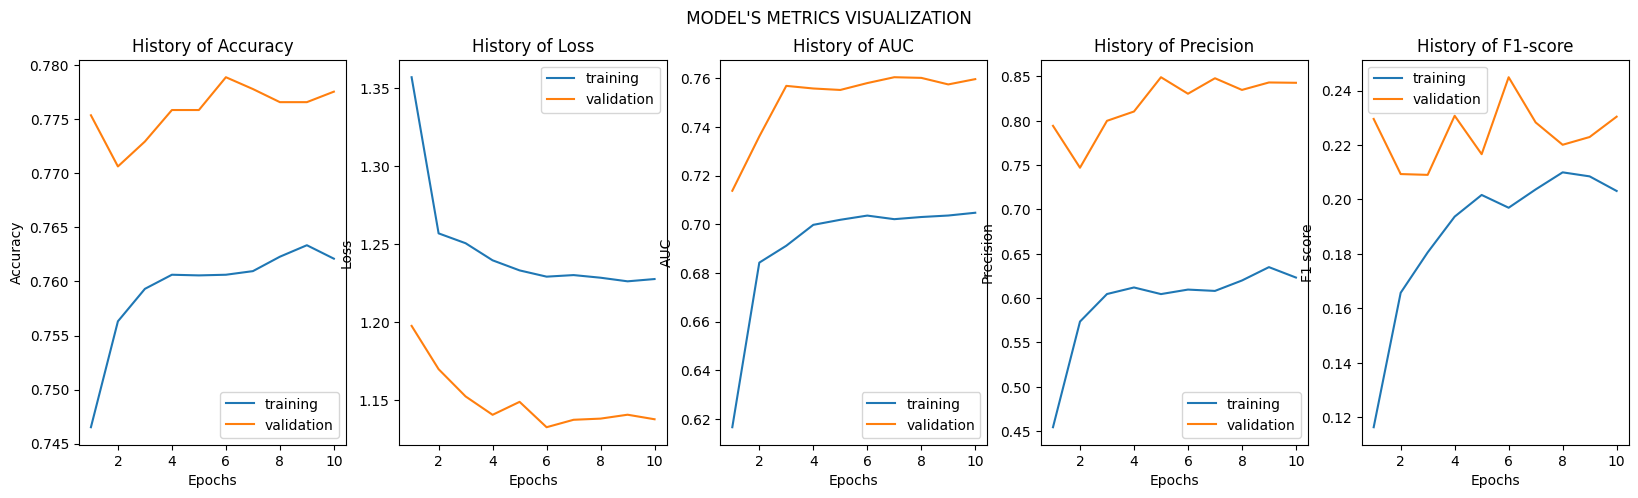

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
scores = model.evaluate(test_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy: 0.7588 - auc: 0.7079 - f1_score: 0.1631 - loss: 1.1651 - precision: 0.6120 - recall: 0.0972


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7578185796737671
Precision =  0.6041666865348816
Recall =  0.09069585800170898
AUC =  0.7074605822563171
F1_score =  0.15453019738197327


In [ ]:
!pip install tensorflow-addons

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-addons

In [ ]:
!pip install tensorflow --upgrade --force-reinstall
!pip install tensorflow-addons --upgrade --force-reinstall

  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-75.6.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached termcolor-2.5.0-py3-none-

  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
Using cached packaging-24.2-py3-none-any.whl (65 kB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.13.3
    Uninstalling typeguard-2.13.3:
      Successfully uninstalled typeguard-2.13.3
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0
ERROR: pip

In [ ]:
##Alzheimer Prediction

import numpy as np
import pandas as pd
import random
import os
from pathlib import Path
import tensorflow as tf
from random import randint
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ke

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ke

AttributeError: _ARRAY_API not found

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from distutils.dir_util import copy_tree, remove_tree
from sklearn.metrics import balanced_accuracy_score as BAS
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D

In [ ]:
tf.random.set_seed(42)
random.seed(42)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
train_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/')
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [ ]:
train_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop = True)

In [ ]:
train_df.head()

,Filepath,Label


In [ ]:
test_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test')

In [ ]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [ ]:
test_df = pd.concat([filepaths, labels], axis=1)
test_df = test_df.sample(frac=1).reset_index(drop = True)

In [ ]:
test_df.head()

,Filepath,Label


In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'
from pathlib import Path
import os
import pandas as pd


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ke

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'
from pathlib import Path
import os
import pandas as pd


test_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test')

filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

test_df = pd.concat([filepaths, labels], axis=1)
test_df = test_df.sample(frac=1).reset_index(drop = True)

test_df.head()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15), # Now 'plt' is defined and can be used
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap='gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ke

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap='gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
custom_model_combined = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same', name = 'last_conv_layer'),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
], name = "cnn_model")

custom_model_combined.summary(line_length=100)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

In [ ]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

custom_model_combined.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              patience = 10,
                              verbose = 1)

filepath = './best_weights.hdf5'

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_loss',
                                mode='min',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
custom_model_combined_history = custom_model_combined.fit(train_images,validation_data=test_images, callbacks=callback_list, epochs=EPOCHS)

In [ ]:
CLASSES = list(test_images.class_indices.keys())

In [ ]:
test_scores = custom_model_combined.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = custom_model_combined.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

In [ ]:
test_ls, pred_ls = test_images.classes,pred

In [ ]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

In [ ]:
##MACHINE LEARNING MODEL
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ke

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Mount your Google Drive
drive.mount('/content/drive')

# Define the path to your dataset
test_data = '/content/drive/My Drive/test'
train_data= '/content/drive/My Drive/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import numpy as np

df['test_data'] = df['test_data'].astype(int)
df['train_data'] = df['train_data'].astype(int)



# Step 2: Load images and convert them into a numerical format (flattening images into feature vectors)
def load_image(image_path, target_size=(64, 64)):
    # Open the image, resize it, and convert it to a numpy array
    image = Image.open(image_path).resize(target_size)  # Resize image to (64, 64)
    return np.array(image).flatten()  # Flatten to 1D array

# Load the images for the training and test sets
X_train = np.array([load_image(image_path) for image_path in train_data['image_path']])
y_train = train_data['label'].values  # Labels are assumed to be in 'label' column

X_test = np.array([load_image(image_path) for image_path in test_data['image_path']])
y_test = test_data['label'].values

# Step 3: Optionally, standardize the data (helps with convergence in some cases)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Initialize and train the Logistic Regression model
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
lr.fit(X_train, y_train)

# Step 5: Evaluate the model on the test set
accuracy = lr.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Step 6: Detailed evaluation
y_pred = lr.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


NameError: name 'df' is not defined

In [ ]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import numpy as np
from glob import glob  # Import glob to find image files


# --- Create DataFrames from image paths ---

# Function to create DataFrame from image directory
def create_df(data_dir):
    image_paths = glob(os.path.join(data_dir, '**/*.jpg'), recursive=True)  # Find all JPG images
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths] # Extract labels from folder names
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df

# Create DataFrames for training and testing data
train_data = create_df('/content/drive/My Drive/train')  # Replace with your train data path
test_data = create_df('/content/drive/My Drive/test')  # Replace with your test data path

# --- Rest of the code remains similar ---

# Convert label columns to integers
train_data['label'] = train_data['label'].astype(int)
test_data['label'] = test_data['label'].astype(int)

# Load images and convert them into a numerical format
def load_image(image_path, target_size=(64, 64)):
    image = Image.open(image_path).resize(target_size)
    return np.array(image).flatten()

X_train = np.array([load_image(image_path) for image_path in train_data['image_path']])
y_train = train_data['label'].values

X_test = np.array([load_image(image_path) for image_path in test_data['image_path']])
y_test = test_data['label'].values

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Logistic Regression model
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
lr.fit(X_train, y_train)

# Evaluate the model
accuracy = lr.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

y_pred = lr.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ValueError: invalid literal for int() with base 10: 'Very Mild Impairment'

In [ ]:
import os
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import numpy as np

# Step 1: Load the image paths and labels from CSV
# Assuming your CSV has columns 'image_path' and 'label'
train_data = pd.read_csv(train_path)  # Path to your training data CSV
test_data = pd.read_csv(test_path)    # Path to your test data CSV

# Step 2: Load images and convert them into a numerical format (flattening images into feature vectors)
def load_image(image_path, target_size=(64, 64)):
    # Open the image, resize it, and convert it to a numpy array
    image = Image.open(image_path).resize(target_size)  # Resize image to (64, 64)
    return np.array(image).flatten()  # Flatten to 1D array

# Load the images for the training and test sets
X_train = np.array([load_image(image_path) for image_path in train_data['image_path']])
y_train = train_data['label'].values  # Labels are assumed to be in 'label' column

X_test = np.array([load_image(image_path) for image_path in test_data['image_path']])
y_test = test_data['label'].values

# Step 3: Optionally, standardize the data (helps with convergence in some cases)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Initialize and train the Support Vector Machine (SVM) model
svm = SVC(kernel='linear')  # You can try other kernels like 'rbf' if needed
svm.fit(X_train, y_train)

# Step 5: Evaluate the model on the test set
accuracy = svm.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Step 6: Detailed evaluation
y_pred = svm.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import numpy as np

# Step 1: Load the image paths and labels from CSV
# Assuming your CSV has columns 'image_path' and 'label'
train_data = pd.read_csv(train_path)  # Path to your training data CSV
test_data = pd.read_csv(test_path)    # Path to your test data CSV

# Step 2: Load images and convert them into a numerical format (flattening images into feature vectors)
def load_image(image_path, target_size=(64, 64)):
    # Open the image, resize it, and convert it to a numpy array
    image = Image.open(image_path).resize(target_size)  # Resize image to (64, 64)
    return np.array(image).flatten()  # Flatten to 1D array

# Load the images for the training and test sets
X_train = np.array([load_image(image_path) for image_path in train_data['image_path']])
y_train = train_data['label'].values  # Labels are assumed to be in 'label' column

X_test = np.array([load_image(image_path) for image_path in test_data['image_path']])
y_test = test_data['label'].values

# Step 3: Optionally, standardize the data (helps with convergence in some cases)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest
rf.fit(X_train, y_train)

# Step 5: Evaluate the model on the test set
accuracy = rf.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Step 6: Detailed evaluation
y_pred = rf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
#VGG16
import os
import cv2
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Mount your Google Drive
drive.mount('/content/drive')

# Define the path to your dataset
test_data_path = '/content/drive/My Drive/test'
train_data_path = '/content/drive/My Drive/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the images
no_impairment = imread(train_data_path+"/No Impairment"+"/NoImpairment (1).jpg")
mild_impairment = imread(train_data_path+"/Mild Impairment"+"/MildImpairment (1).jpg")
moderate_impairment = imread(train_data_path+"/Moderate Impairment"+"/ModerateImpairment (1).jpg")
very_mild_impairment = imread(train_data_path+"/Very Mild Impairment"+"/VeryMildImpairment (1).jpg")


# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes = axes.flatten()

axes[0].imshow(no_impairment, cmap='gray')
axes[0].set_title('No Impairment', fontsize=18)
axes[0].axis('off')

axes[1].imshow(mild_impairment, cmap='gray')
axes[1].set_title('Mild Impairment', fontsize=18)
axes[1].axis('off')

axes[2].imshow(moderate_impairment, cmap='gray')
axes[2].set_title('Moderate Impairment', fontsize=18)
axes[2].axis('off')

axes[3].imshow(very_mild_impairment, cmap='gray')
axes[3].set_title('Very Mild Impairment', fontsize=18)
axes[3].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Data shape
random_image=train_data_path+"/No Impairment"+"/NoImpairment (1).jpg"
print("Image Shape:",cv2.imread(random_image).shape)

Image Shape: (128, 128, 3)


In [ ]:
def data_preprocessing(output_size, val_split=0.1):
    # ImageDataGenerator for training with validation split
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.2,
                                       shear_range=0.2,
                                       rotation_range=15,
                                       fill_mode='nearest',
                                       horizontal_flip=True,
                                       validation_split=val_split)

    # Training data generator
    training_set = train_datagen.flow_from_directory(train_data_path,
                                                     target_size=(output_size, output_size),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     subset='training')

    # Validation data generator
    validation_set = train_datagen.flow_from_directory(train_data_path,
                                                       target_size=(output_size, output_size),
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       subset='validation')

    return training_set, validation_set


# Splitting Data
training_set, validation_set = data_preprocessing(output_size=150, val_split=0.1)

Found 9264 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.


In [ ]:
# Training & Validation data Size
print("Training set distribution:", dict(pd.Series(training_set.classes).value_counts()))
print("\nValidation set distribution:", dict(pd.Series(validation_set.classes).value_counts()))

Training set distribution: {0: 2343, 1: 2313, 2: 2304, 3: 2304}

Validation set distribution: {0: 260, 1: 257, 2: 256, 3: 256}


In [6]:
# Load the pre-trained VGG16 model (excluding the top layers) with weights from ImageNet
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16 so that they are not trainable
vgg_base.trainable = False

# Initialize the Sequential model
model = Sequential([
    # VGG16 as the base feature extractor
    vgg_base,

    # Flatten the output of the VGG16 base
    Flatten(),

    # Fully Connected Layer 1
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Fully Connected Layer 2
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),


    # Output Layer with Softmax Activation (for 4 classes)
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,847,044 (64.27 MB)

 Trainable params: 2,131,588 (8.13 MB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(training_set, validation_data = validation_set, batch_size = 64, epochs= 10, verbose = 1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


290/290 ━━━━━━━━━━━━━━━━━━━━ 5945s 20s/step - accuracy: 0.4651 - loss: 1.4939 - val_accuracy: 0.6200 - val_loss: 0.9585
Epoch 2/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 134s 391ms/step - accuracy: 0.6599 - loss: 0.8138 - val_accuracy: 0.6676 - val_loss: 0.7836
Epoch 3/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 141s 386ms/step - accuracy: 0.7171 - loss: 0.6752 - val_accuracy: 0.6929 - val_loss: 0.7670
Epoch 4/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 143s 392ms/step - accuracy: 0.7472 - loss: 0.5913 - val_accuracy: 0.6569 - val_loss: 0.8241
Epoch 5/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 115s 388ms/step - accuracy: 0.7570 - loss: 0.5797 - val_accuracy: 0.7230 - val_loss: 0.5933
Epoch 6/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 114s 386ms/step - accuracy: 0.7594 - loss: 0.5496 - val_accuracy: 0.7269 - val_loss: 0.6248
Epoch 7/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 153s 423ms/step - accuracy: 0.7809 - loss: 0.5289 - val_accuracy: 0.6346 - val_loss: 0.8385
Epoch 8/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 133s 389ms/step - accuracy: 0.7837 - loss: 0.515

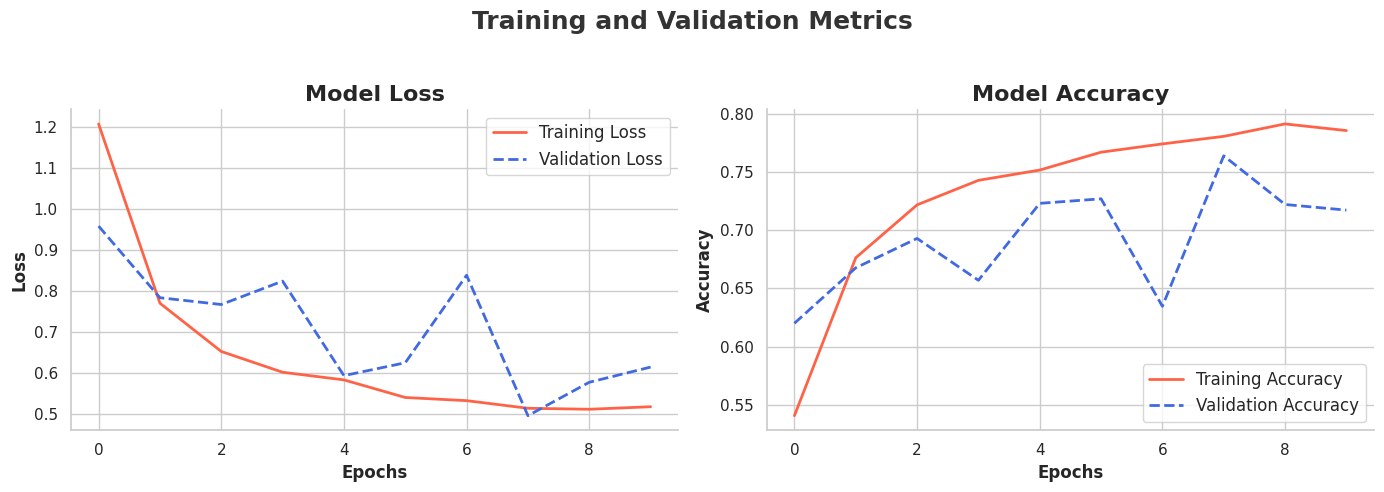

In [ ]:
# Model's Performance
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plotting Loss
axes[0].plot(history.history['loss'], color='#FF6347', label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], color='#4169E1', label='Validation Loss', linewidth=2, linestyle='--')
axes[0].set_title('Model Loss', fontsize=16, weight='bold')
axes[0].set_xlabel('Epochs', fontsize=12, weight='bold')
axes[0].set_ylabel('Loss', fontsize=12, weight='bold')
axes[0].legend(loc='upper right', fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plotting Accuracy
axes[1].plot(history.history['accuracy'], color='#FF6347', label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], color='#4169E1', label='Validation Accuracy', linewidth=2, linestyle='--')
axes[1].set_title('Model Accuracy', fontsize=16, weight='bold')
axes[1].set_xlabel('Epochs', fontsize=12, weight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, weight='bold')
axes[1].legend(loc='lower right', fontsize=12)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)


plt.suptitle('Training and Validation Metrics', fontsize=18, weight='bold', color='#333')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Evaluate model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_data_path,
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 1279 images belonging to 4 classes.
40/40 ━━━━━━━━━━━━━━━━━━━━ 441s 11s/step - accuracy: 0.6582 - loss: 0.6965
Test Loss: 0.6930
Test Accuracy: 67.01%


In [ ]:
# Function for making predictions
def prediction(img_path, class_labels):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    return predicted_class, prediction[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


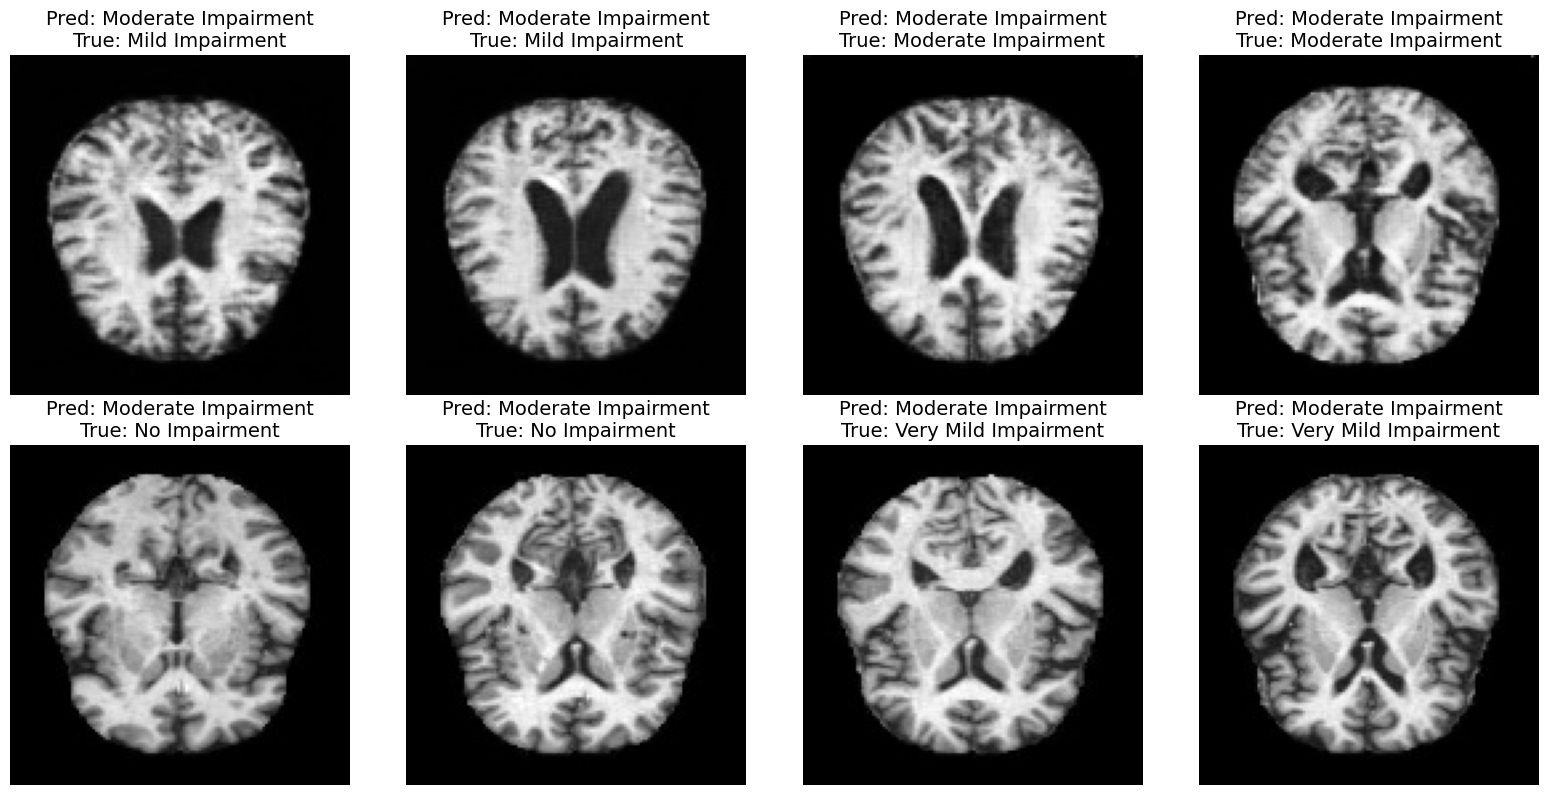

In [8]:
# Function for making predictions
def prediction(img_path, class_labels):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    return predicted_class, prediction[0]


# Define the folder path and class labels
folder_path = train_data_path
class_labels = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Prepare a list to store file paths and corresponding class names
image_paths = []
class_names = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

for class_name in class_names:
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    selected_images = random.sample(image_files, 2)  # Randomly select 2 images
    for img_file in selected_images:
        image_paths.append((os.path.join(class_folder, img_file), class_name))


fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, (img_path, true_class) in enumerate(image_paths):
    predicted_class, probabilities = prediction(img_path, class_labels) # prediction function is now defined
    img = plt.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}", fontsize=14)

plt.tight_layout()
plt.show()